In [403]:
import os
import csv

# Directory containing the files
directory = "namesbystate"

# Dictionary to store the data
data = {}

# List all files in the directory
files = os.listdir(directory)

# Filter out files that match the pattern "STATE.*.txt"
state_files = [f for f in files if f.startswith("STATE")]

# Read each state file
for state_file in state_files:
    state_abbr = state_file.split('.')[1]  # Extract state abbreviation from the filename
    
    # Initialize the state dictionary if not already present
    if state_abbr not in data:
        data[state_abbr] = {}
    
    with open(os.path.join(directory, state_file), 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            year = int(row[2])
            name_gender_key = f"{row[3]}_{row[1]}"
            
            # Initialize the year dictionary if not already present
            if year not in data[state_abbr]:
                data[state_abbr][year] = {}
            
            data[state_abbr][year][name_gender_key] = int(row[4])
# print(data["AZ"][1910]["Mary_F"])


# filtered init

In [393]:
import os
import csv
from collections import Counter

# Directory containing the files
directory = "namesbystate"

# Dictionary to store the data
data = {}

# Counter for all names
name_counter = Counter()

# List all files in the directory
files = os.listdir(directory)

# Filter out files that match the pattern "STATE.*.txt"
state_files = [f for f in files if f.startswith("STATE")]

# Read each state file
for state_file in state_files:
    state_abbr = state_file.split('.')[1]  # Extract state abbreviation from the filename
    
    with open(os.path.join(directory, state_file), 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            year = int(row[2])
            name_gender_key = f"{row[3]}_{row[1]}"
            count = int(row[4])

            # Add count to the name counter
            name_counter[name_gender_key] += count

            # Initialize the state and year dictionary if not already present
            data.setdefault(state_abbr, {}).setdefault(year, {})
            data[state_abbr][year][name_gender_key] = count

# Function to filter names based on commonality
def filter_names(data, num_names_to_remove, num_names_to_keep):
    # Get names to remove and to keep
    names_to_remove = set(name for name, _ in name_counter.most_common(num_names_to_remove))
    print(names_to_remove)
    names_to_keep = set(name for name, _ in name_counter.most_common(num_names_to_remove + num_names_to_keep)) - names_to_remove
    print(names_to_keep)

    # Filter the data
    filtered_data = {}
    for state, years in data.items():
        filtered_data[state] = {}
        for year, names in years.items():
            filtered_data[state][year] = {name: count for name, count in names.items() if name in names_to_keep}
    
    return filtered_data
def scale_to_common_total(data, common_total=1000):
    scaled_data = {}
    for state, years in data.items():
        scaled_data[state] = {}
        for year, names in years.items():
            total_count = sum(names.values())
            scale_factor = common_total / total_count
            scaled_data[state][year] = {name: round(count * scale_factor) for name, count in names.items()}
    return scaled_data

# Example: Scale and then round counts
data = filter_names(data, 20, 300)
scaled_data = scale_to_common_total(data)



{'Patricia_F', 'William_M', 'James_M', 'Anthony_M', 'Christopher_M', 'Matthew_M', 'Richard_M', 'John_M', 'Michael_M', 'David_M', 'Jennifer_F', 'Mary_F', 'Daniel_M', 'Robert_M', 'Linda_F', 'Barbara_F', 'Joseph_M', 'Thomas_M', 'Charles_M', 'Elizabeth_F'}
{'Dennis_M', 'Randy_M', 'Glenn_M', 'Shirley_F', 'Audrey_F', 'Shawn_M', 'Eva_F', 'Jackson_M', 'Olivia_F', 'Debra_F', 'Kevin_M', 'Isabella_F', 'Christine_F', 'Mia_F', 'Angela_F', 'Theodore_M', 'Brandon_M', 'Ruth_F', 'Danny_M', 'George_M', 'Leah_F', 'Beverly_F', 'Kenneth_M', 'Travis_M', 'Sarah_F', 'Aaron_M', 'Carol_F', 'Melanie_F', 'Nicholas_M', 'Diane_F', 'Philip_M', 'Eleanor_F', 'Ronald_M', 'Clarence_M', 'Alexandra_F', 'Carolyn_F', 'Jesus_M', 'Paul_M', 'Gerald_M', 'Dale_M', 'Heather_F', 'Madison_F', 'Rachel_F', 'Francis_M', 'Emma_F', 'Brittany_F', 'Denise_F', 'Mark_M', 'Kyle_M', 'Edwin_M', 'Jacob_M', 'Ernest_M', 'Luke_M', 'Stephen_M', 'Edward_M', 'Marie_F', 'Josephine_F', 'Angel_M', 'Robin_F', 'Charlotte_F', 'Roy_M', 'Craig_M', 'Betty_F',

In [398]:
print(sum(scaled_data["CA"][2022].values()))

987


# filter one year

In [413]:
from gensim import corpora
from collections import Counter

# Select the year of interest
year_of_interest = 2022

# Initialize the Counter for names
name_counter = Counter()

# Extract data for the specified year
for state, years in data.items():
    if year_of_interest in years:
        for name, count in years[year_of_interest].items():
            name_counter[name] += count  # Count the names

# Determine the top X most frequent names to remove
X = 0  # Set X as needed
names_to_remove = set(name for name, _ in name_counter.most_common(X))

# Keep the next top Y names in the dictionary
Y = 300  # Set Y as needed
names_to_keep = set(name for name, _ in name_counter.most_common(X + Y)) - names_to_remove

# Process the data for the year of interest, applying filtering and then normalization
common_total = 1000  # Common total for normalization
documents = []

for state, years in data.items():
    if year_of_interest in years:
        # Apply the filtering
        filtered_names = {name: count for name, count in years[year_of_interest].items() if name in names_to_keep}

        # Calculate the total count after filtering
        total_count = sum(filtered_names.values())

        # Calculate the scale factor for normalization
        scale_factor = common_total / total_count if total_count else 0

        # Scale and round the counts
        scaled_names = {name: round(count * scale_factor) for name, count in filtered_names.items()}

        # Create the document for the state
        document = [name for name, scaled_count in scaled_names.items() for _ in range(scaled_count)]
        documents.append(document)

# Create a dictionary from the data
dictionary = corpora.Dictionary(documents)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]


In [401]:
from gensim import corpora, models
from gensim.models import TfidfModel

# Extract 2022 data
documents = []
for state, years in data.items():
    for y in range(2022, 2023, 5):
        if y in years:
            names = []
            for name, count in years[y].items():
                names.extend([name] * count)
            documents.append(names)


# Create a dictionary from the data
dictionary = corpora.Dictionary(documents)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]

# failed weighting attempts

In [261]:
from collections import defaultdict
import math

# Calculate document frequencies for each name
doc_freq = defaultdict(int)
for document in documents:
    unique_names = set(document)
    for name in unique_names:
        doc_freq[name] += 1

# Calculate a custom weight for each name (inverse document frequency)
total_docs = len(documents)
power = 3.3 # Use a value less than 1 to lessen the impact, or greater than 1 to increase it
custom_weights = {name: (math.log((total_docs + 1) / (freq + 1)) + 1) ** power for name, freq in doc_freq.items()}


# Apply the custom weights to the corpus
weighted_corpus = [[(term_id, frequency * custom_weights[dictionary[term_id]]) for term_id, frequency in doc] for doc in corpus]


In [259]:
from collections import defaultdict
import math

power = 1

# Calculate document frequencies for each name
doc_freq = defaultdict(int)
for document in documents:
    for name in document:
        doc_freq[name] += 1

# Total number of documents
total_docs = len(documents)

# Adjust the weighting scheme
custom_weights = {}
for name, freq in doc_freq.items():
    idf = math.log((total_docs * 10 + 1) / (freq + 1)) + 1  # Add 1 to avoid zero IDF for terms in all documents
    # Adjust weight calculation to penalize frequent terms; use a small constant to avoid division by zero
    custom_weights[name] = 1 / (idf ** power + 1e-10)  # Adding a small constant to avoid division by zero

# Apply the custom weights to the corpus
weighted_corpus = []
for doc in corpus:
    weighted_doc = []
    for term_id, frequency in doc:
        name = dictionary[term_id]
        weighted_frequency = frequency * custom_weights[name]
        weighted_doc.append((term_id, weighted_frequency))
    weighted_corpus.append(weighted_doc)


# Running the model

In [422]:
# Run LDA
# alpha is document topic distribution
# eta is topic word distribution
num_topics = 2  # You can adjust this
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, alpha=0.01, eta=0.1)

# Print the topics
for topic in lda.print_topics():
    print(topic)


(0, '0.013*"Liam_M" + 0.012*"Noah_M" + 0.010*"Charlotte_F" + 0.010*"Oliver_M" + 0.010*"James_M" + 0.010*"Sophia_F" + 0.010*"William_M" + 0.009*"Levi_M" + 0.009*"Amelia_F" + 0.009*"Evelyn_F"')
(1, '0.013*"Liam_M" + 0.013*"Oliver_M" + 0.012*"Olivia_F" + 0.011*"Noah_M" + 0.010*"Emma_F" + 0.010*"Charlotte_F" + 0.009*"Henry_M" + 0.009*"Elijah_M" + 0.009*"Theodore_M" + 0.009*"Amelia_F"')


In [423]:
from gensim import models

# Assuming lda is your trained LdaModel and dictionary is your Gensim dictionary

num_topics = lda.num_topics  # Number of topics in the model
topic_word_distributions = {topic: dict(lda.show_topic(topic, topn=len(dictionary))) for topic in range(num_topics)}

# Function to find distinctive words for each topic
def find_distinctive_words(topic_word_distributions):
    distinctive_words = {}
    for topic in topic_word_distributions:
        other_topics = set(topic_word_distributions.keys()) - {topic}
        word_scores = {}

        for word, prob in topic_word_distributions[topic].items():
            max_prob_other_topics = max([topic_word_distributions[ot].get(word, 0) for ot in other_topics])
            distinctiveness_score = prob - max_prob_other_topics
            word_scores[word] = distinctiveness_score

        # Sort words by distinctiveness score
        distinctive_words[topic] = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

    return distinctive_words

# Get distinctive words for each topic
distinctive_words_per_topic = find_distinctive_words(topic_word_distributions)

# Print distinctive words for each topic
for topic, words in distinctive_words_per_topic.items():
    print(f"Topic {topic}:")
    for word, score in words[:20]:  # Adjust the number to get more or fewer words
        print(f"  {word}: {score}")
    print("\n")


Topic 0:
  Levi_M: 0.004178893286734819
  Evelyn_F: 0.0034947218373417854
  Mateo_M: 0.0032931165769696236
  Sophia_F: 0.003066770266741514
  Jack_M: 0.002575295977294445
  Sebastian_M: 0.0021485225297510624
  Willow_F: 0.0017928807064890862
  Julian_M: 0.0017207395285367966
  Santiago_M: 0.0015158841852098703
  Luna_F: 0.0014711897820234299
  Camila_F: 0.001468359725549817
  Luca_M: 0.0014111865311861038
  Anthony_M: 0.0012450169306248426
  Jonathan_M: 0.0012449503410607576
  Samuel_M: 0.0012003970332443714
  Logan_M: 0.0011876756325364113
  Riley_F: 0.0011661520693451166
  Charles_M: 0.001150030642747879
  Eliana_F: 0.0011451293248683214
  Avery_F: 0.0011122729629278183


Topic 1:
  Wyatt_M: 0.0038315732963383198
  Olivia_F: 0.0032105697318911552
  Harper_F: 0.00317917438223958
  Elijah_M: 0.0030073397792875767
  Oliver_M: 0.0028045205399394035
  Emma_F: 0.0023387023247778416
  Grayson_M: 0.002020479179918766
  Asher_M: 0.0018968828953802586
  Nolan_M: 0.0017383331432938576
  Maveric

In [378]:
time_slices = [len(i) for i in documents]
print(time_slices)

[14336, 5518, 36346, 5524, 180391, 101012, 5896, 25338, 61731, 11920, 95684, 51712, 40991, 60217, 46610, 66923, 27930, 20849, 339697, 2364, 77873, 15688, 25754, 4162, 5925, 360023, 72625, 77298, 22804, 43889, 34793, 38651, 7205, 47048, 21089, 7898, 46738, 1980, 99960, 51946, 10795, 5959, 31164, 166198, 38024, 5532, 98080, 25040, 59951, 96325, 6214]


In [424]:
state_topic_distributions = {}

for state, bow in zip(states, corpus):
    state_topic_distributions[state] = lda.get_document_topics(bow, minimum_probability=0)

# Print the topic distribution for each state
for state, distribution in state_topic_distributions.items():
    print(f"State: {state}, Distribution: {distribution}")


State: ID, Distribution: [(0, 0.31353086), (1, 0.6864691)]
State: DC, Distribution: [(0, 0.68487895), (1, 0.31512108)]
State: KY, Distribution: [(0, 0.34077507), (1, 0.6592249)]
State: DE, Distribution: [(0, 0.589588), (1, 0.410412)]
State: FL, Distribution: [(0, 0.6847607), (1, 0.3152393)]
State: PA, Distribution: [(0, 0.42324173), (1, 0.5767583)]
State: RI, Distribution: [(0, 0.59398603), (1, 0.40601397)]
State: IA, Distribution: [(0, 0.30291948), (1, 0.69708055)]
State: WA, Distribution: [(0, 0.4282004), (1, 0.5717996)]
State: WV, Distribution: [(0, 0.1915285), (1, 0.8084715)]
State: NC, Distribution: [(0, 0.51749295), (1, 0.48250705)]
State: MO, Distribution: [(0, 0.33095247), (1, 0.66904753)]
State: AL, Distribution: [(0, 0.37756383), (1, 0.6224361)]
State: AZ, Distribution: [(0, 0.7739577), (1, 0.22604224)]
State: MN, Distribution: [(0, 0.301949), (1, 0.698051)]
State: TN, Distribution: [(0, 0.3877916), (1, 0.6122084)]
State: OR, Distribution: [(0, 0.4323681), (1, 0.56763184)]
St

  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  
Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSP

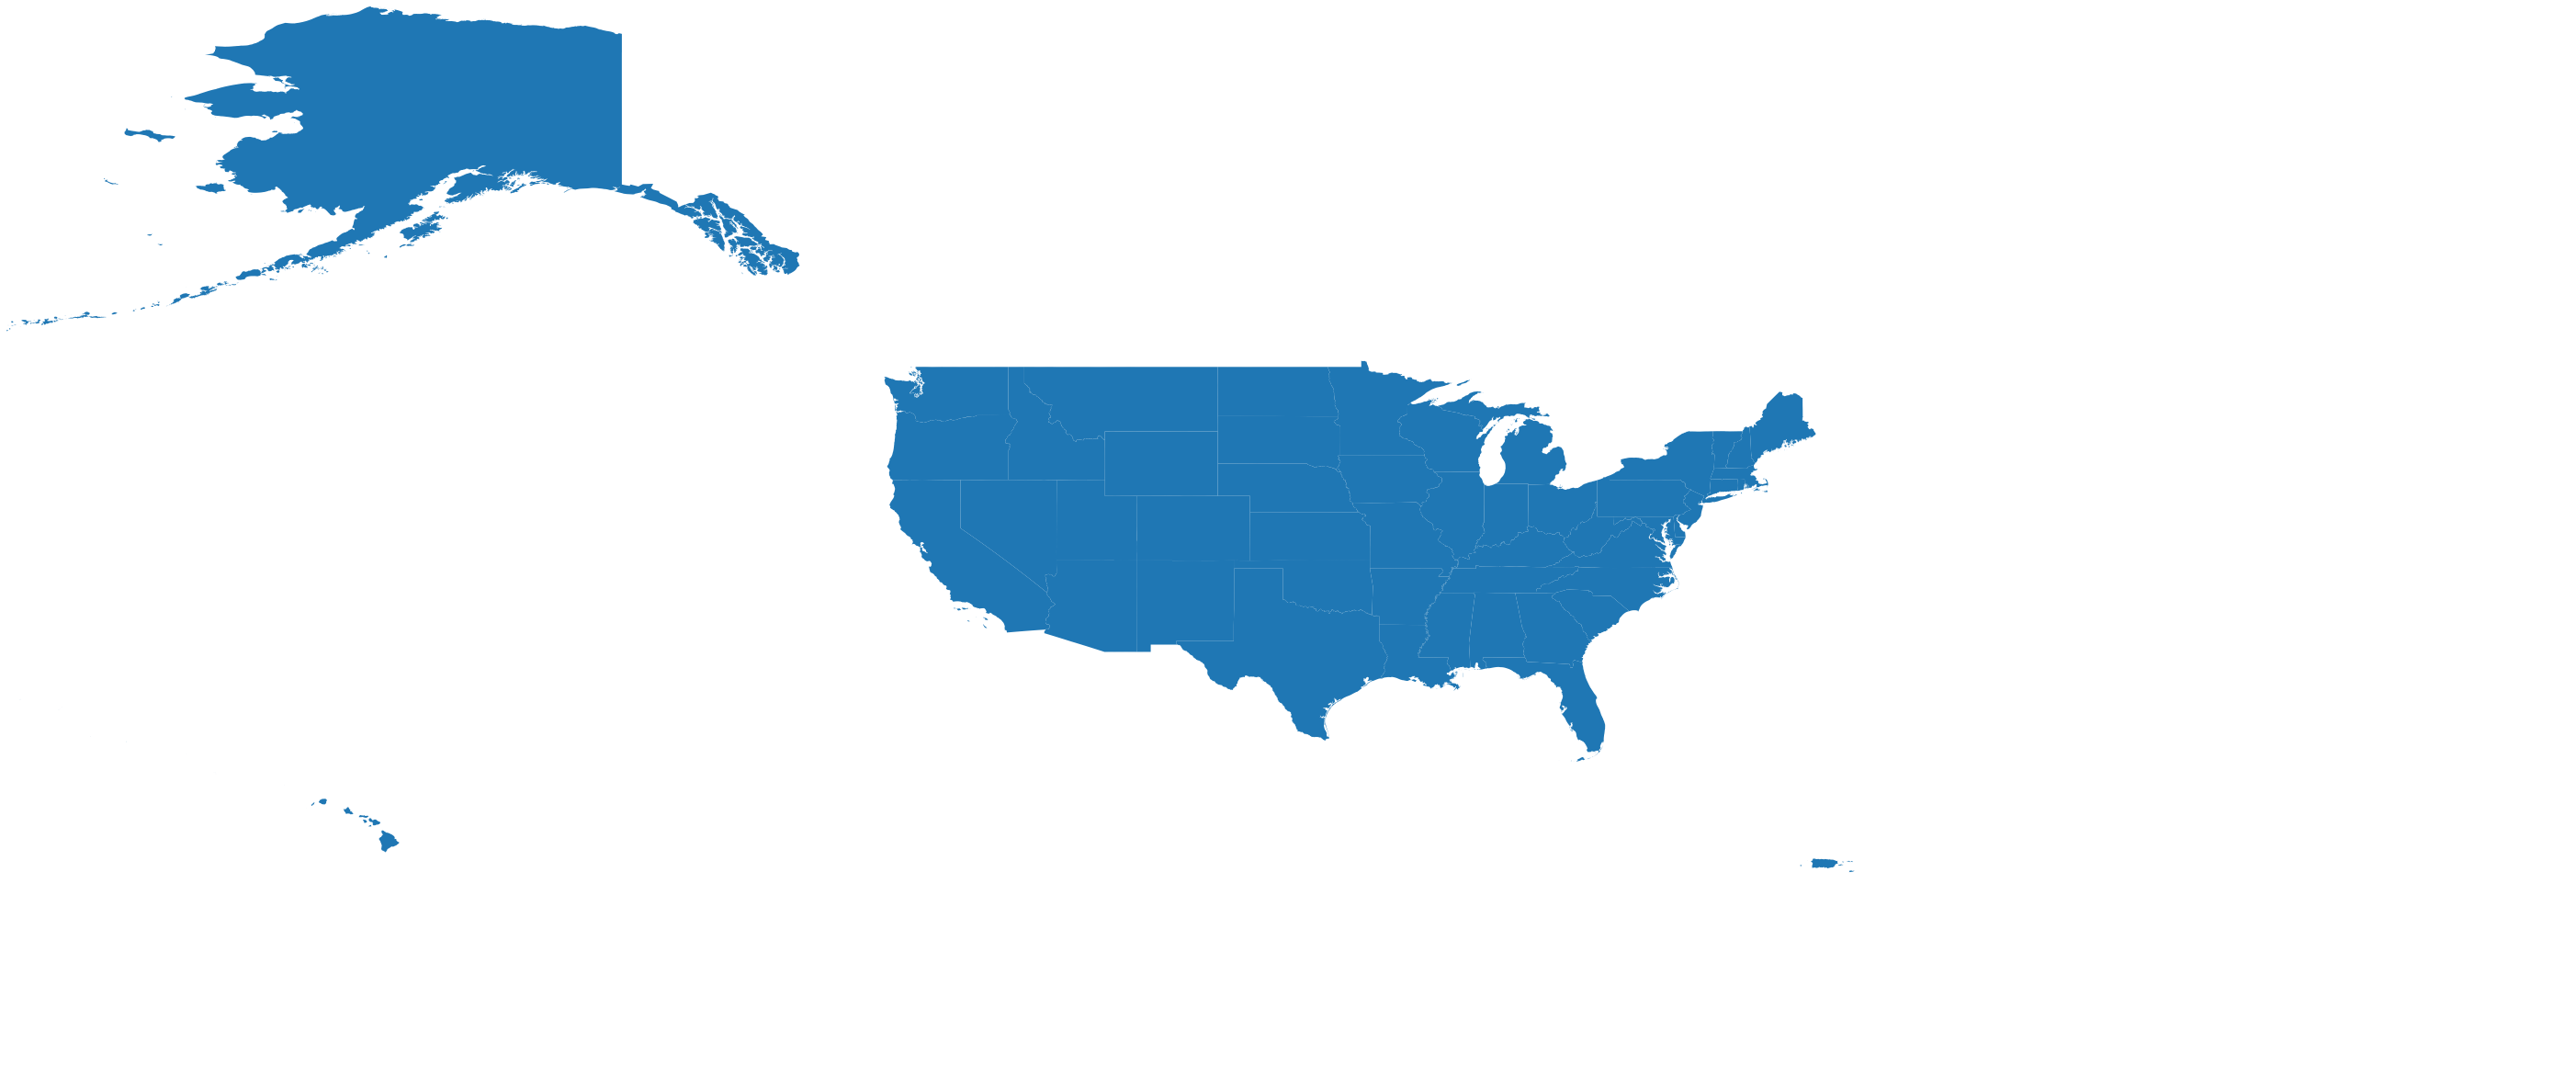

In [86]:
shapefile_path =  "/Users/hanmingyang/Downloads/cb_2018_us_nation_5m/cb_2018_us_nation_5m.shp"
shapefile_path = "/Users/hanmingyang/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
# Read the shapefile using Geopandas
gdf = gpd.read_file(shapefile_path)

# Print the first few rows of the GeoDataFrame
print(gdf.head())

# Print the column names to understand the attributes
print(gdf.columns)

# # Plot the shapefile to visualize it
# gdf.plot()

fig, ax = plt.subplots(1, 1, figsize=(50, 50))  # You can adjust the figsize as needed

# Plot the GeoDataFrame
gdf.plot(ax=ax)

# Remove the axis
ax.axis('off')

# Set the aspect of the plot to equal
ax.set_aspect('equal')

# Center the plot
ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2] - 200])  # set x limits to the bounds of the shapes
ax.set_ylim([gdf.total_bounds[1] + 20, gdf.total_bounds[3]])  # set y limits to the bounds of the shapes

# Show the plot
plt.show()

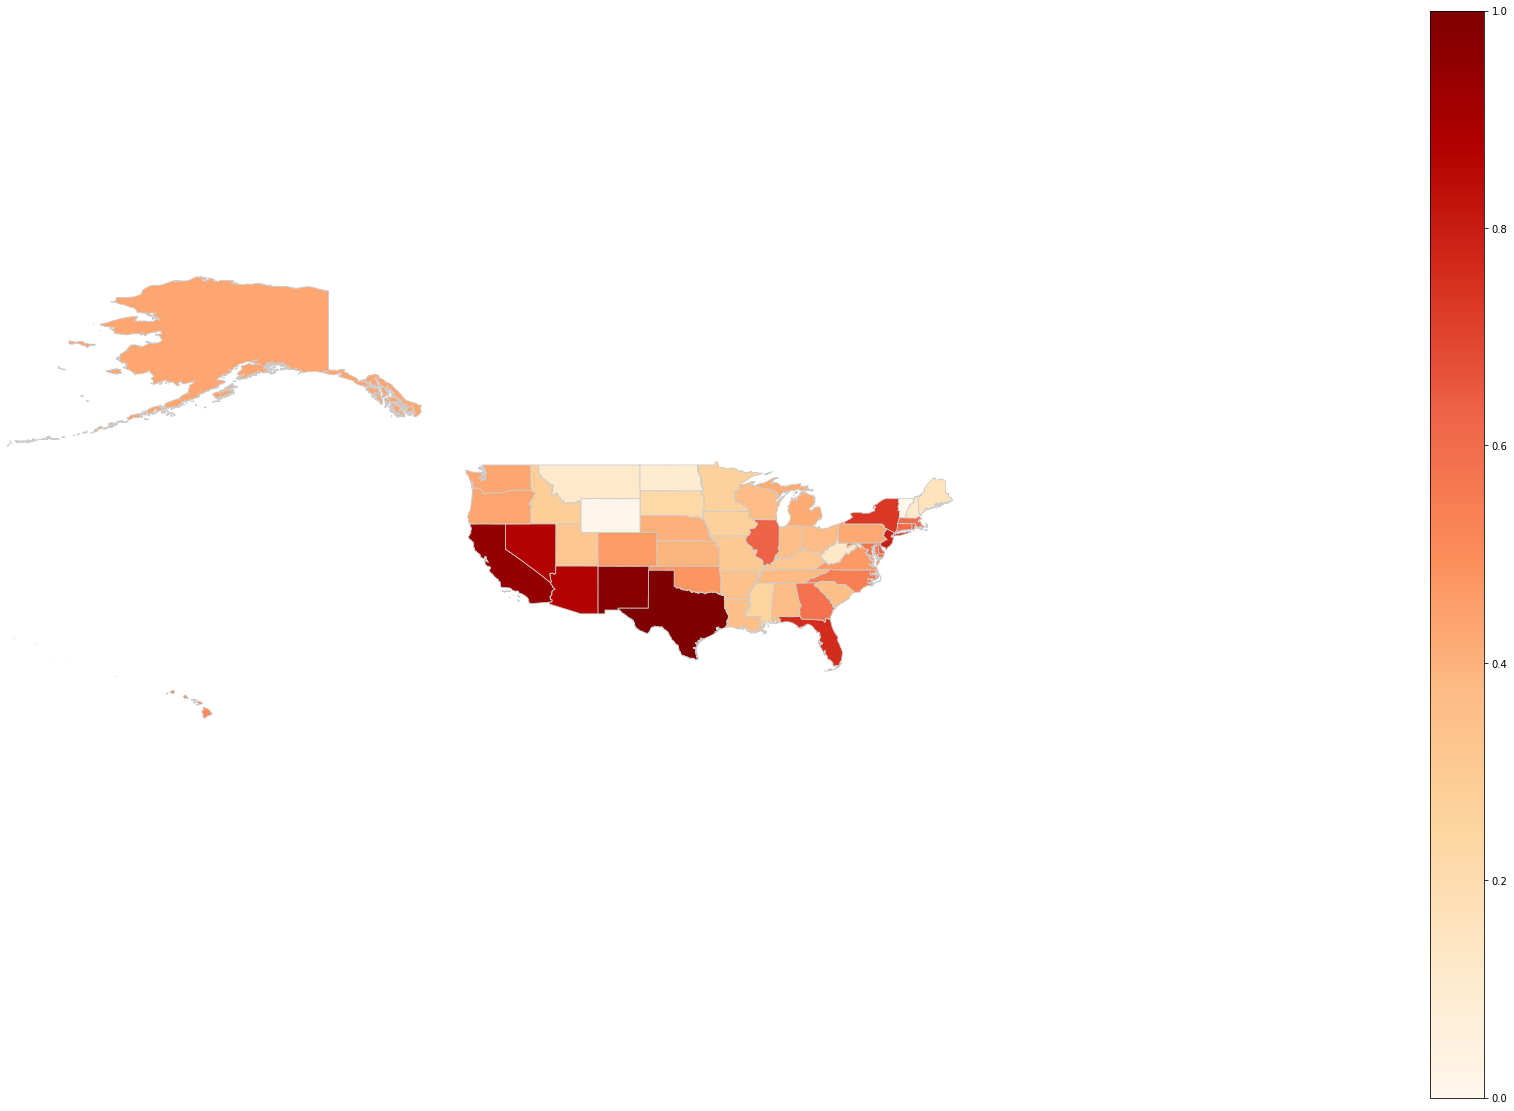

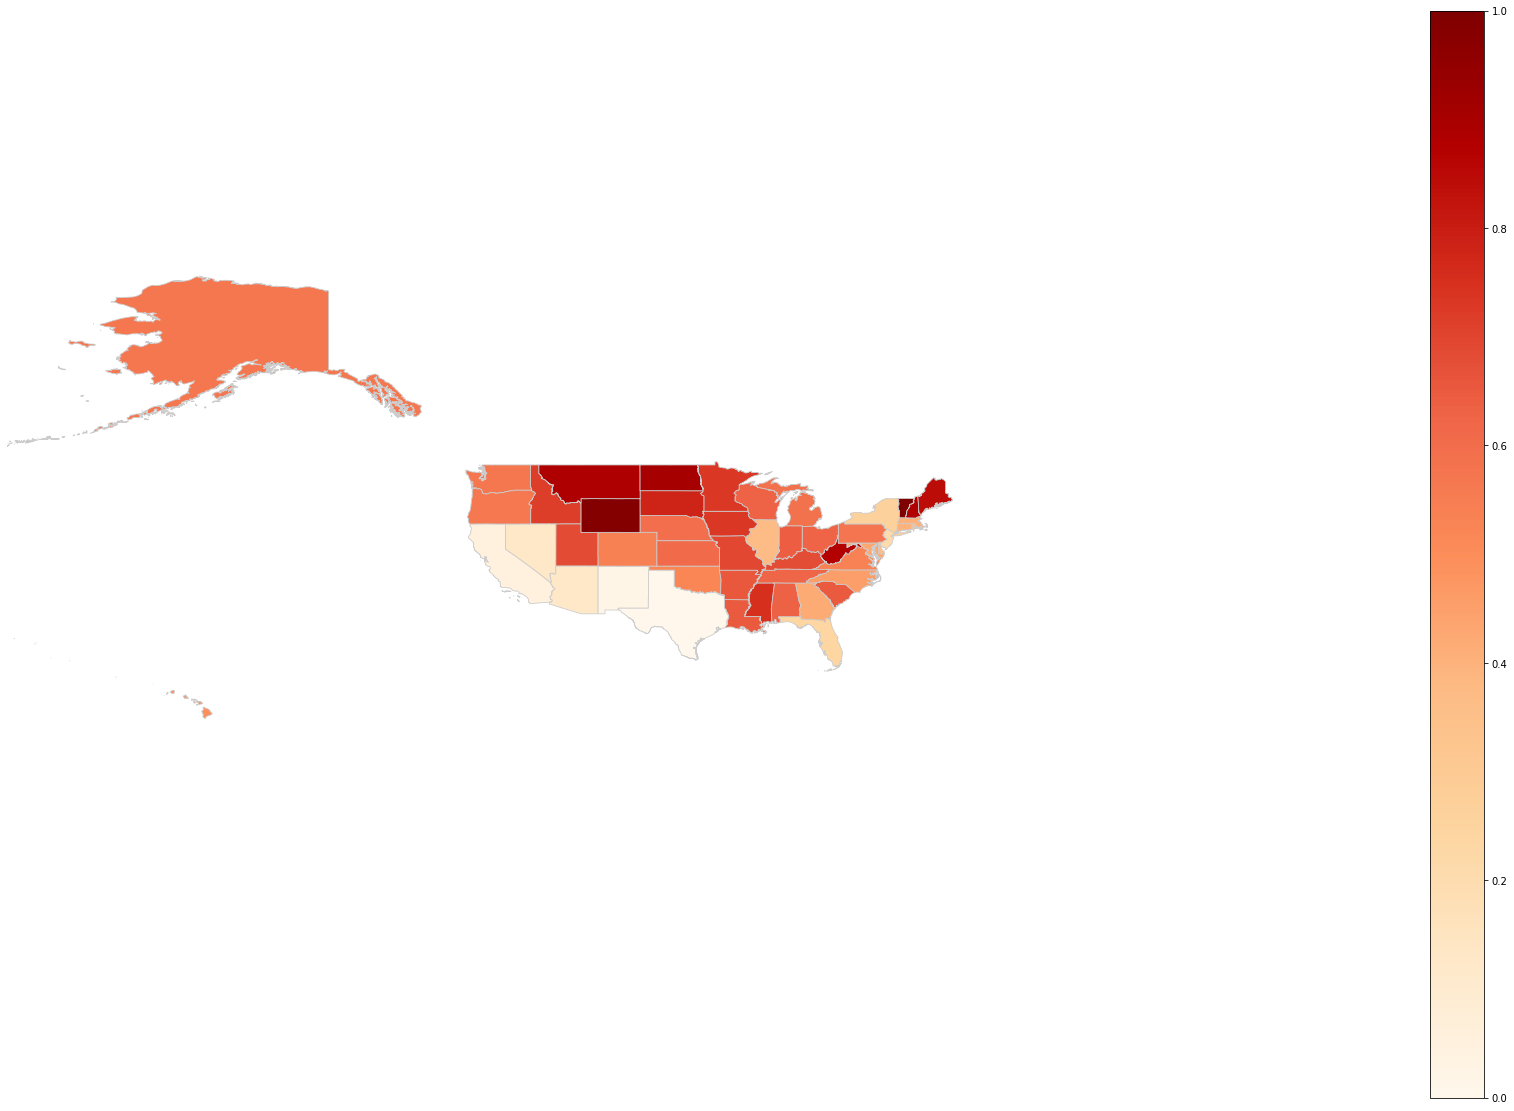

In [425]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

for i in range(lda.num_topics):
    topic_id = i  # Replace with your specific topic ID
    state_intensity = {state: distribution[topic_id] for state, distribution in state_topic_distributions.items()}

    # Load the shapefile using Geopandas
    shapefile_path = "/Users/hanmingyang/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
    gdf = gpd.read_file(shapefile_path)

    # Ensure that the GeoDataFrame has a column with state abbreviations that match your distribution keys
    gdf['state_abbr'] = gdf['STUSPS']  # Replace 'STUSPS' with the actual column name for state abbreviations if different

    # Convert the dictionary to a DataFrame
    intensity_df = pd.DataFrame(list([(i[0], i[1][1]) for i in state_intensity.items()]), columns=['index', 'intensity'])

    # Merge the DataFrame with the GeoDataFrame
    gdf = gdf.merge(intensity_df, how='left', left_on='state_abbr', right_on='index')

    # Set the size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))

    # Plot the GeoDataFrame with intensity coloring
    gdf.plot(column='intensity', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

    # Remove the axis
    ax.axis('off')

    # Set the aspect of the plot to equal and adjust the limits if needed
    ax.set_aspect('equal')
    ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2] - 200])  # set x limits to the bounds of the shapes
    ax.set_ylim([gdf.total_bounds[1] + 20, gdf.total_bounds[3]])  # set y limits to the bounds of the shapes

    # Add a colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap='OrRd'), ax=ax)

    # Show the plot
    plt.show()
